In [1]:
import biosig
import json

In [2]:
HDR=json.loads(biosig.header('BCICIV_2b_gdf/B0101T.gdf'))

In [3]:
HDR.keys()

dict_keys(['TYPE', 'VERSION', 'Filename', 'NumberOfChannels', 'NumberOfRecords', 'SamplesPerRecords', 'NumberOfSamples', 'Samplingrate', 'StartOfRecording', 'TimezoneMinutesEastOfUTC', 'NumberOfSweeps', 'NumberOfGroupsOrUserSpecifiedEvents', 'Patient', 'CHANNEL', 'EVENT'])

In [4]:
sr  = HDR['Samplingrate']
sr

250.0

In [42]:
import pandas as pd
events = pd.json_normalize(HDR['EVENT'])
events[:20]

,TYP,POS,DUR,Description
0,0x7ffe,0.000,0.000,start of a new segment (after a break)
1,0x0114,1.996,60.000,eeg:Idling EEG - eyes open
2,0x0115,66.996,60.000,eeg:Idling EEG - eyes closed
3,0x0439,131.996,15.000,eye blinks
4,0x0437,151.996,15.000,eye rotation (clockwise)
5,0x0436,171.996,15.000,vertical eye movement
6,0x0435,191.996,15.000,horizontal eye movement
7,0x7ffe,209.004,0.000,start of a new segment (after a break)
8,0x0300,220.556,8.000,"Start of Trial, Trigger at t=0s"
9,0x0301,223.556,1.252,"class1, Left hand"


In [6]:
data=biosig.data('BCICIV_2b_gdf/B0101T.gdf').T
data.shape

(6, 604803)

In [7]:
import numpy as np
def time_ind_conversion(sr, t):
    return int(np.round(sr*t))

In [25]:
t_start = time_ind_conversion(sr, events.POS[9])
t_end = time_ind_conversion(sr, events.POS[9]+events.DUR[9])
left_test = data[:, t_start:t_end]
left_test.shape

(6, 313)

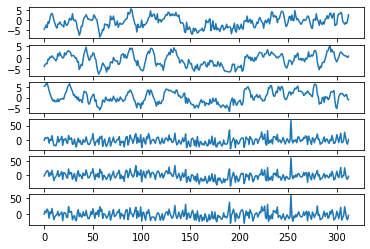

In [27]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(left_test[i, :])
    

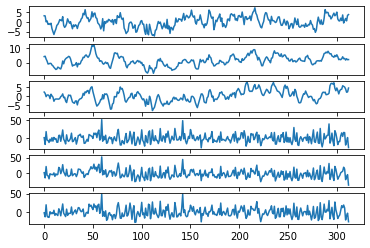

In [43]:
t_start = time_ind_conversion(sr, events.POS[11])
t_end = time_ind_conversion(sr, events.POS[11]+events.DUR[11])
right_test = data[:, t_start:t_end]
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(right_test[i, :])

## High pass approach

It is noted in the literature that while performing any motor imagery tasks, two major frequency band of EEG spectrum i.e mu (7-12 Hz) as well as beta (12-30 Hz) bands are actively involved.

In [18]:
# from A1
from scipy.signal import butter, sosfiltfilt, sosfreqz 

def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y

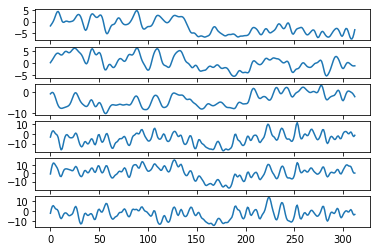

In [200]:
lowcut = 0.1
highcut= 30
left_filtered = butter_bandpass_filter(left_test, lowcut, highcut, sr)
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(left_filtered[i,:])

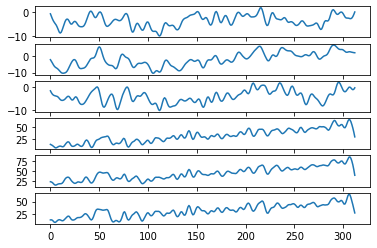

In [201]:
right_filtered = butter_bandpass_filter(right_test, lowcut, highcut, sr)
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(right_filtered[i,:])

## FFT approach

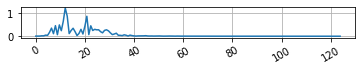

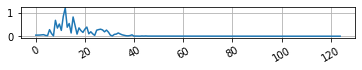

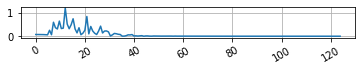

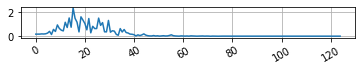

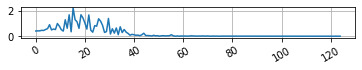

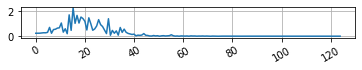

In [50]:
from scipy.fft import fft, fftfreq
N = left_filtered.shape[1]
T = 1/sr
for i in range(6):
    yf = fft(left_filtered[i,:])
    xf = fftfreq(N, T)[:N//2]
    plt.subplot(6, 1, i+1)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.xticks(rotation=30)
    plt.show()


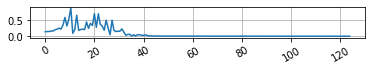

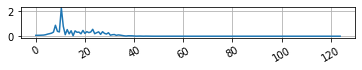

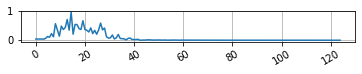

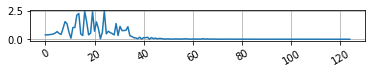

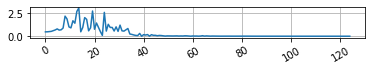

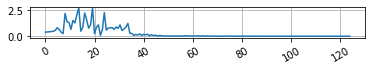

In [51]:
N = right_filtered.shape[1]
T = 1/sr
for i in range(6):
    yf = fft(right_filtered[i,:])
    xf = fftfreq(N, T)[:N//2]
    plt.subplot(6, 1, i+1)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.xticks(rotation=30)
    plt.show()


## Classification on raw data (just for fun...)

In [235]:
import os
data_path = './BCICIV_2b_gdf/'
files = [os.path.join(data_path, f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
train_files = [f for f in files if f[-5]=='T']
test_files = [f for f in files if f[-5]=='E']
# for testing purposes only
train_files = train_files[:5]
#test_files = test_files[:2]

In [159]:
data_len = 1125
def populate_data(files):
    labels = []
    data = []
    for i in files:
        HDR = json.loads(biosig.header(i))
        sr  = HDR['Samplingrate']
        events = pd.json_normalize(HDR['EVENT'])
        mi_events = events[events.Description.apply(lambda x: 'class' in x)].reset_index(drop=True)
        all_data = biosig.data(i).T
        for j in range(len(mi_events)):
            t_start = time_ind_conversion(sr, mi_events.POS[j])
            t_end = time_ind_conversion(sr, mi_events.POS[j]+mi_events.DUR[j])
            #only use the eeg channels
            event_data = all_data[:3, t_start:t_end]
            event_len = event_data.shape[1]
            #pad data to the same length
            if event_len!= data_len:
                event_data = np.pad(event_data, ((0, 0),(0, data_len-event_len)))
            data.append(event_data)
            labels.append(mi_events.Description[j])
    return data, labels
train_data, train_label = populate_data(train_files)
test_data, test_label = populate_data(test_files)

In [237]:
i = test_files[-1]
HDR = json.loads(biosig.header(i))
sr  = HDR['Samplingrate']
events = pd.json_normalize(HDR['EVENT'])
mi_events = events[events.Description.apply(lambda x: 'class' in x)].reset_index(drop=True)
all_data = biosig.data(i).T
events.Description.unique()

array(['start of a new segment (after a break)',
       'eeg:Idling EEG - eyes open', 'eeg:Idling EEG - eyes closed',
       'eye blinks', 'eye rotation (clockwise)', 'vertical eye movement',
       'horizontal eye movement', 'Start of Trial, Trigger at t=0s',
       'cue unknown/undefined (used for BCI competition) ',
       'Feedback (continuous) - onset (BCI experiment)',
       'Rejection of whole trial'], dtype=object)

In [238]:
j=0
t_start = time_ind_conversion(sr, mi_events.POS[j])
t_end = time_ind_conversion(sr, mi_events.POS[j]+mi_events.DUR[j])
event_data = all_data[:, t_start:t_end]
#if len(event_data)!= data_len:
#    event_data = np.pad(event_data, (0, data_len-len(event_data)))
event_data.shape[1]
mi_events

IndexError: index out of bounds

In [ ]:
for j in range(len(mi_events)):
    t_start = time_ind_conversion(sr, mi_events.POS[j])
    t_end = time_ind_conversion(sr, mi_events.POS[j]+mi_events.DUR[j])
    event_data = all_data[:, t_start:t_end]
    if len(event_data)!= data_len:
        event_data = np.pad(event_data, (0, data_len-len(event_data)))

In [155]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, SimpleRNN, LSTM, GRU
from keras.optimizers import SGD, Nadam, Adam, RMSprop
from keras.callbacks import TensorBoard
from keras.utils import np_utils
import scipy.io
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [168]:
def reshape_data(data, label):
    x = np.dstack(data)
    x = x.reshape(x.shape[2], x.shape[1], x.shape[0])
    lb = preprocessing.LabelBinarizer()
    y = lb.fit_transform(label)
    return x, y

data, label = reshape_data(train_data, train_label)
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.2, random_state=42)

In [169]:
train_x.shape, test_x.shape

((576, 1125, 3), (144, 1125, 3))

In [173]:
train_y.shape, test_y.shape

((576, 1), (144, 1))

In [171]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(1125, 3)))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(5))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1125, 20)          1920      
_________________________________________________________________
lstm_13 (LSTM)               (None, 1125, 10)          1240      
_________________________________________________________________
lstm_14 (LSTM)               (None, 5)                 320       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 12        
Total params: 3,492
Trainable params: 3,492
Non-trainable params: 0
_________________________________________________________________


In [175]:
optim = Nadam(lr=0.001)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.fit(train_x, train_y, epochs=15, batch_size=20)

Epoch 1/15
29/29 [==============================] - 28s 822ms/step - loss: nan - accuracy: 0.4745
Epoch 2/15
29/29 [==============================] - 25s 859ms/step - loss: nan - accuracy: 0.5294
Epoch 3/15
29/29 [==============================] - 23s 797ms/step - loss: nan - accuracy: 0.5169
Epoch 4/15
29/29 [==============================] - 22s 752ms/step - loss: nan - accuracy: 0.5165
Epoch 5/15
29/29 [==============================] - 22s 751ms/step - loss: nan - accuracy: 0.5045
Epoch 6/15
29/29 [==============================] - 23s 785ms/step - loss: nan - accuracy: 0.5017
Epoch 7/15
29/29 [==============================] - 23s 796ms/step - loss: nan - accuracy: 0.5361
Epoch 8/15
29/29 [==============================] - 23s 778ms/step - loss: nan - accuracy: 0.5185
Epoch 9/15
29/29 [==============================] - 23s 777ms/step - loss: nan - accuracy: 0.4690
Epoch 10/15
29/29 [==============================] - 23s 784ms/step - loss: nan - accuracy: 0.4886
Epoch 11/15
29/29 [

In [188]:
cond1_ind = np.where(train_y==[0])[0]
cond2_ind = np.where(train_y==[1])[0]
cond1_avg = np.mean(train_x[cond1_ind, :,:], axis=0)
cond2_avg = np.mean(train_x[cond2_ind, :,:], axis=0)

In [191]:
cond1_avg.shape

(1125, 3)

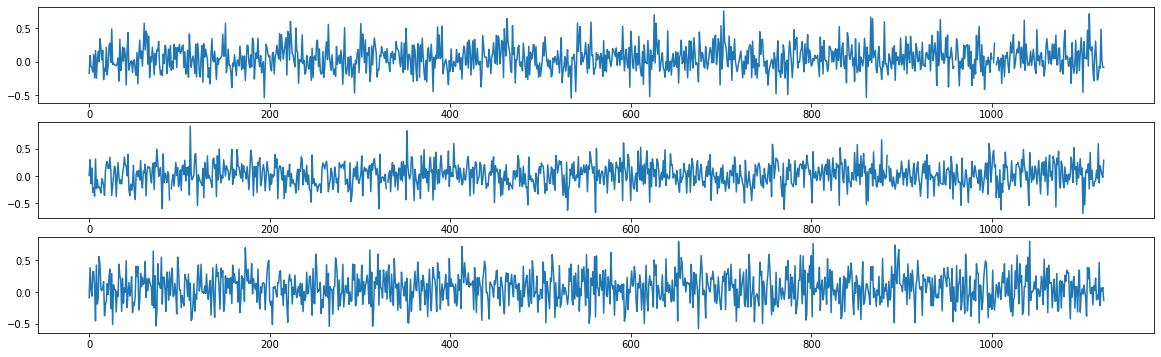

In [203]:
plt.figure(figsize=(20,6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(cond1_avg[:,i])

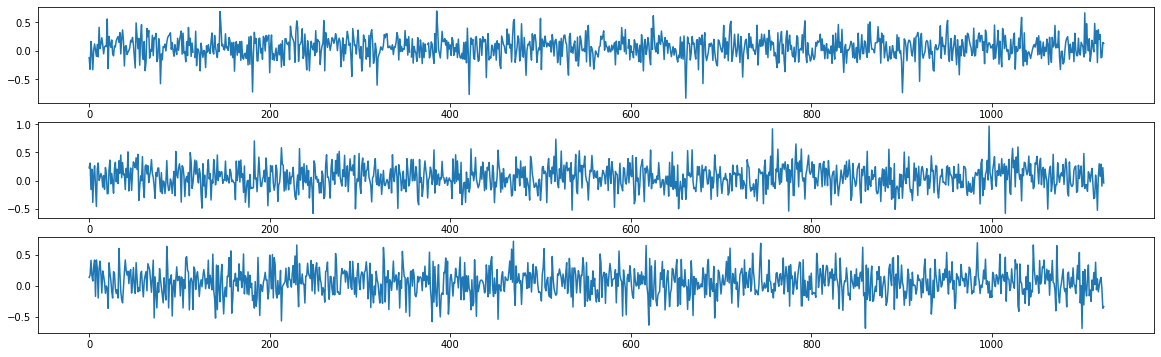

In [199]:
plt.figure(figsize=(20,6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(cond2_avg[:,i])

In [ ]:
lowcut = 0.1
highcut= 30
left_filtered = butter_bandpass_filter(left_test, lowcut, highcut, sr)



In [229]:
def populate_filt_data(files):
    lowcut = 0.1
    highcut= 30
    labels = []
    data = []
    for i in files:
        HDR = json.loads(biosig.header(i))
        sr  = HDR['Samplingrate']
        events = pd.json_normalize(HDR['EVENT'])
        mi_events = events[events.Description.apply(lambda x: 'class' in x)].reset_index(drop=True)
        all_data = biosig.data(i).T
        for j in range(len(mi_events)):
            t_start = time_ind_conversion(sr, mi_events.POS[j])
            t_end = time_ind_conversion(sr, mi_events.POS[j]+mi_events.DUR[j])
            #only use the eeg channels
            event_data = all_data[:3, t_start:t_end]
            filtered = butter_bandpass_filter(event_data, lowcut, highcut, sr)
            event_len = filtered.shape[1]
            #pad data to the same length
            if event_len!= data_len:
                filtered = np.pad(filtered, ((0, 0),(0, data_len-event_len)))
            data.append(filtered)
            labels.append(mi_events.Description[j])
    return data, labels
train_data_filt, train_label = populate_filt_data(train_files)
data_filt, label = reshape_data(train_data_filt, train_label)
train_x_filt, test_x_filt, train_y_filt, test_y_filt = train_test_split(data_filt, label, test_size=0.2, random_state=42)



In [230]:
cond1_ind_filt = np.where(train_y==[0])[0]
cond2_ind_filt = np.where(train_y==[1])[0]
cond1_avg_filt = np.mean(train_x_filt[cond1_ind_filt, :,:], axis=0)
cond2_avg_filt = np.mean(train_x_filt[cond2_ind_filt, :,:], axis=0)

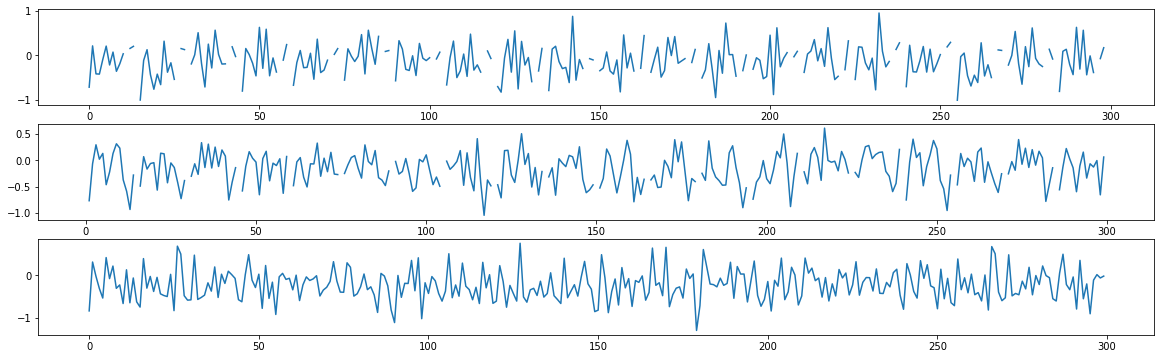

In [233]:
# why blank spot? Use csp?
plt.figure(figsize=(20,6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(cond2_avg_filt[300:600,i])